# Comparacao da reconstrucao de dados apos PCA

In [246]:
from scipy.io import loadmat

from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

Carrega os dados e checa informacoes sobre ele

In [247]:
dados = loadmat("/home/pedrosergiot/Downloads/bi_f6.mat")

dados.keys()

dict_keys(['__header__', '__version__', '__globals__', 'xin'])

In [248]:
dados = dados['xin']

dados = np.transpose(dados)[:,0:15]

dados.shape

(6540, 15)

Temos 6540 observacoes de 15 canais de EEG (canal 16 excluido por ser a gravacao do estimulo usado). A seguir aplica-se a PCA usando o metodo do Scikit-Learn, baseado em SVD, reconstruindo o sinal com algumas das PCs (numero de PCs usadas na reconstrucao e aumentado progressivamente). Ao final e mostrado o RMSE entre o sinal original e o reconstruido em funcao do numero de PCs usadas

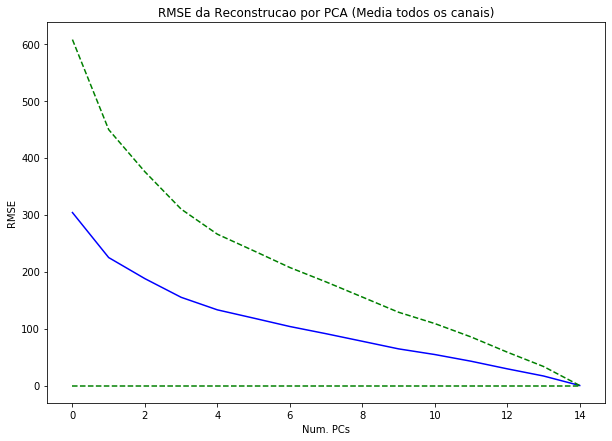

In [252]:
mse = []
for pcs in range(1,dados.shape[1]+1):
    
    pca = PCA(n_components=pcs)
    transformed_dados = pca.fit_transform(dados-dados.mean(axis=0))
    transformed_dados = pca.inverse_transform(transformed_dados) + dados.mean(axis=0)
    
    transformed_dados = np.sqrt(np.square(transformed_dados-dados))
    mse.append(transformed_dados.sum(axis=0)/transformed_dados.shape[0])
    
mse = np.asarray(mse)
mse_avg = np.mean(mse, axis=1)
mse_std = np.mean(mse, axis=1)

plt.rcParams['figure.figsize'] = [10, 7]

plt.plot(mse_avg, color='blue')
plt.plot(mse_avg + mse_std, color='green', linestyle='--')
plt.plot(mse_avg - mse_std, color='green', linestyle='--')

plt.xlabel('Num. PCs')
plt.ylabel('RMSE')
plt.title('RMSE da Reconstrucao por PCA (Media todos os canais)');

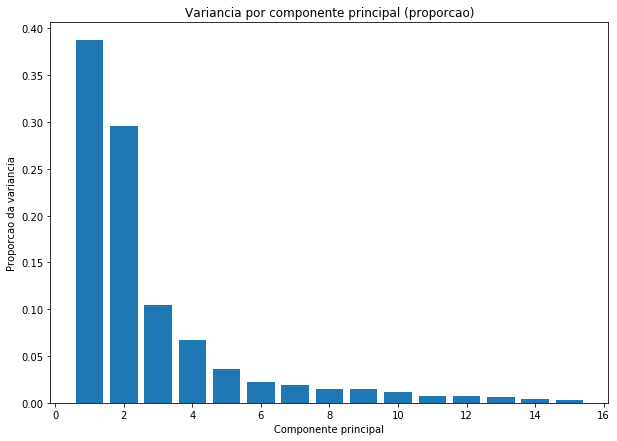

In [253]:
pca = PCA()
pca.fit_transform(dados-dados.mean(axis=0))

plt.bar(range(1,16), pca.explained_variance_ratio_)
plt.title('Variancia por componente principal (proporcao)')
plt.xlabel('Componente principal')
plt.ylabel('Proporcao da variancia');

Aplicacao da PCA e reconstrucao seguindo metodo do calculo dos autovetores e autovalores da matriza de covariancia. Novamente e mostrado ao final o RMSE do sinal reconstruindo em relacao ao sinal original plotado em funcao do numero de PCs usadas

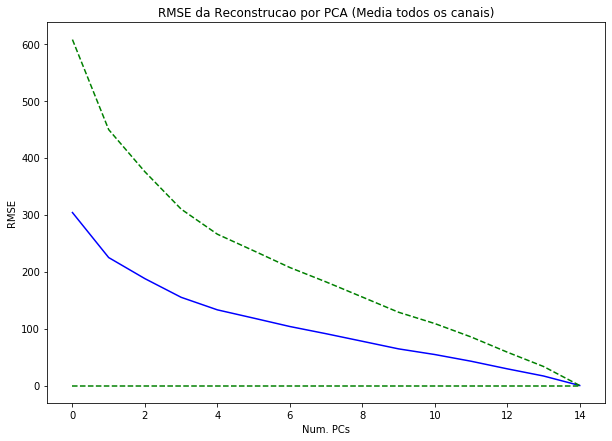

In [254]:
mse = []

dados_sem_media = dados-np.mean(dados, axis=0)

cov_matrix = np.cov(dados_sem_media, rowvar=False, ddof=0)
w, v = np.linalg.eig(cov_matrix)

sort_index = np.argsort(-w)
v = v[:,sort_index]

array_pcs = []

for pcs in range(1, dados.shape[1]+1):
    
    transformed_dados = np.array(np.dot(dados_sem_media,v[:,0:pcs]), ndmin=2)
    transformed_dados = np.dot(transformed_dados,np.transpose(np.array(v[:,0:pcs], ndmin=2))) + np.mean(dados, axis=0)
    
    transformed_dados = np.sqrt(np.square(transformed_dados-dados))
    mse.append(transformed_dados.sum(axis=0)/transformed_dados.shape[0])
        
mse = np.asarray(mse)
mse_avg = np.mean(mse, axis=1)
mse_std = np.mean(mse, axis=1)



plt.plot(mse_avg, color='blue')
plt.plot(mse_avg + mse_std, color='green', linestyle='--')
plt.plot(mse_avg - mse_std, color='green', linestyle='--')

plt.xlabel('Num. PCs')
plt.ylabel('RMSE')
plt.title('RMSE da Reconstrucao por PCA (Media todos os canais)');

Resultado praticamente identico, como poder ser conferido no grafico e pelos valores RMSE (omitidos para nao poluir demais esse notebook)

# Aplicacao da PCA nos dados transpostos (6540 variaveis com 15 observacoes)

Testando agora o caso em que temos cada ponto da serie temporal como uma variavel aleatoria, sendo os 15 canais as realizacoes dessas variaveis aleatorias

In [255]:
dados = loadmat("/home/pedrosergiot/Downloads/bi_f6.mat")

dados = dados['xin'][0:15,:]
dados.shape

(15, 6540)

In [256]:
mse = []
for pcs in range(1,dados.shape[1]+1):
    
    pca = PCA(n_components=pcs)
    transformed_dados = pca.fit_transform(dados-dados.mean(axis=0))
    transformed_dados = pca.inverse_transform(transformed_dados) + dados.mean(axis=0)
    
    transformed_dados = np.sqrt(np.square(transformed_dados-dados))
    mse.append(transformed_dados.sum(axis=0)/transformed_dados.shape[0])
    
mse = np.asarray(mse)
mse_avg = np.mean(mse, axis=1)
mse_std = np.mean(mse, axis=1)

plt.plot(mse_avg, color='blue')
plt.plot(mse_avg + mse_std, color='green', linestyle='--')
plt.plot(mse_avg - mse_std, color='green', linestyle='--')

plt.xlabel('Num. PCs')
plt.ylabel('RMSE')
plt.title('RMSE da Reconstrucao por PCA (Media todos os canais)')

ValueError: n_components=16 must be between 0 and min(n_samples, n_features)=15 with svd_solver='full'

O calculo da PCA atraves da implementacao via SVD falha devido ao sinal ter agora mais variaveis aletorias do que realizacoes. No caso da abordagem Naive Bayes, proposta pelo professor Seixas, poderiamos janelar o sinal e usar essas janelas como novas realizacoes (o que tambem diminuiria o numero de variaveis aleatorias). 

A seguir e realizada a tentativa do calculo da PCA atraves da implementacao mais classica, calculando autovetores e autovalores da matriz de correlacao. Essa abordagem permite que realizemos os calculos mesmo com numero reduzido de realizacoes, embora o RMSE apos 14 componentes principais nao faca muito sentido (variancia zero e RMSE complexo). Uma discussao sobre isso pode ser encontrada nos seguintes links:

https://stats.stackexchange.com/questions/123318/why-are-there-only-n-1-principal-components-for-n-data-if-the-number-of-dime



/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


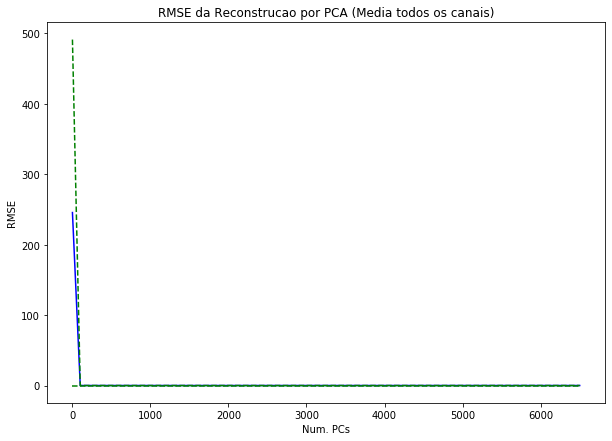

In [257]:
mse = []

dados_sem_media = dados-np.mean(dados, axis=0)

cov_matrix = np.cov(dados_sem_media, rowvar=False, ddof=0)
w, v = np.linalg.eig(cov_matrix)

sort_index = np.argsort(-w)
v = v[:,sort_index]

array_pcs = []

for pcs in range(1, dados.shape[1]+1, 100):
    
    transformed_dados = np.array(np.dot(dados_sem_media,v[:,0:pcs]), ndmin=2)
    transformed_dados = np.dot(transformed_dados,np.transpose(np.array(v[:,0:pcs], ndmin=2))) + np.mean(dados, axis=0)
    
    transformed_dados = np.sqrt(np.square(transformed_dados-dados))
    mse.append(transformed_dados.sum(axis=0)/transformed_dados.shape[0])
    
    array_pcs.append(pcs)
    
array_pcs = np.asarray(array_pcs)
    
mse = np.asarray(mse)
mse_avg = np.mean(mse, axis=1)
mse_std = np.mean(mse, axis=1)



plt.plot(array_pcs, mse_avg, color='blue')
plt.plot(array_pcs,mse_avg + mse_std, color='green', linestyle='--')
plt.plot(array_pcs,mse_avg - mse_std, color='green', linestyle='--')

plt.xlabel('Num. PCs')
plt.ylabel('RMSE')
plt.title('RMSE da Reconstrucao por PCA (Media todos os canais)');

E a variancia explicada por cada componente (proporcionalmente) e dada a seguir (mostradas apenas as primeiras componentes das 6540)

/home/pedrosergiot/deep_learning_2/lib/python3.7/site-packages/matplotlib/transforms.py:796: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.array(args, dtype=float).reshape(2, 2)


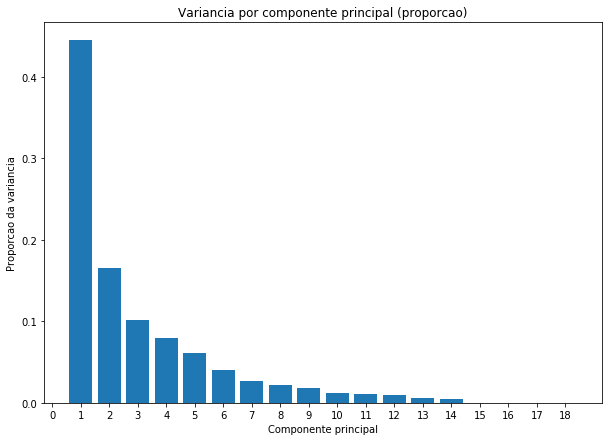

In [260]:
pca = PCA()
pca.fit_transform(dados-dados.mean(axis=0))

plt.bar(range(1,19), w[0:18]/sum(w))
plt.title('Variancia por componente principal (proporcao)')
plt.xlabel('Componente principal')
plt.ylabel('Proporcao da variancia')
plt.xticks(np.arange(0, 19, step=1));